In [1]:
import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format



In [2]:
df = wr.get_clean_data(start2018=True)
sdf = s.get_summary_df(df)
sdf = wr.add_date_features(sdf)

In [3]:
train, test = wr.split_data(sdf)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

In [4]:
pd.concat([train.tail(1), validate.head(1)])

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name
order_date,,,,,,,,,,,,,,
2021-12-31,Houston TranStar,Local Government,Houston,"Presidio Networked Solutions Group, LLC",2022-01-04,712.76,2021,4,12,52,4,365,December,Friday
2022-01-01,Teacher Retirement System of Texas,State Agency,Austin,"Presidio Networked Solutions Group, LLC",2022-04-28,"62,756.88",2022,1,1,52,5,1,January,Saturday


In [5]:
pd.concat([validate.tail(1), test.head(1)])

,customer_name,customer_type,customer_city,reseller_name,shipped_date,purchase_amount,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name
order_date,,,,,,,,,,,,,,
2022-06-30,Travis County,Local Government,Austin,"Netsync Network Solutions, Inc.",2022-07-31,"33,530.00",2022,2,6,26,3,181,June,Thursday
2022-07-01,Austin Community College,Higher Ed,Austin,"Presidio Networked Solutions Group, LLC",2022-07-05,"13,918.00",2022,3,7,26,4,182,July,Friday


## Create time series with daily resampling

In [6]:
X_train_ts = train.purchase_amount.copy().resample('W').sum()
X_validate_ts = validate.purchase_amount.copy().resample('W').sum()
X_test_ts = test.purchase_amount.copy().resample('W').sum()

In [7]:
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()

In [8]:
X_validate.shape[0] == len(X_validate_ts)

True

In [9]:
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

In [10]:
# back to mean!!! median's RMSE is very high
baseline = X_train_ts.mean()

In [11]:
baseline # weekly baseline = 4574450.59

4574450.593110048

In [12]:
def evaluate(target_name: str, model_name: str):
    RMSE_train = round(np.sqrt(mean_squared_error(X_train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(X_validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
    # plot
    plt.figure(figsize = (12,4))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

In [13]:
def evaluate_rmse(target_name: str, model_name: str):
    RMSE_train = round(np.sqrt(mean_squared_error(X_train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(X_validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
def plot_model(target_name: str, model_name: str):
    plt.figure(figsize = (12,4))
    plt.plot(X_train[target_name], label='Train', linewidth=1)
    plt.plot(X_validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

In [14]:
target = 'purchase_amount'

In [15]:
predictions_train = pd.DataFrame(index=X_train.index)
predictions_validate = pd.DataFrame(index=X_validate.index)
predictions_train['baseline'] = baseline
predictions_validate['baseline'] = baseline

purchase_amount -- RMSE train: 2494618
purchase_amount -- RMSE validate: 2446953


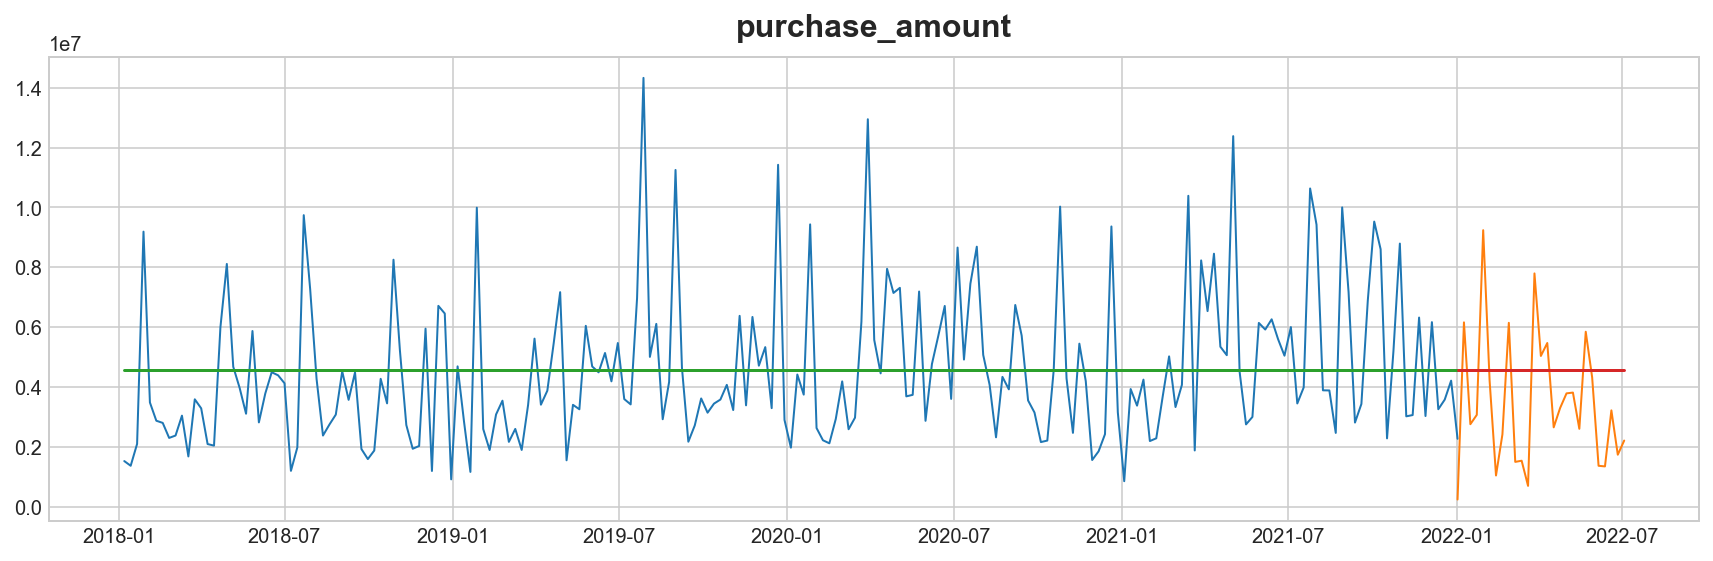

In [16]:
evaluate(target_name='purchase_amount', model_name='baseline')

In [17]:
scores

,model_name,train_score,validate_score
0,baseline,2494618,2446953


### Moving Average

In [18]:
def model_moving_average(span=3):
    '''
    Create moving averages statistical models.
    Saves results to predictions_train and predictions_validate
    Evaluate models and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # assign the period for the moving average
    span = span
    # identify the model
    model_name = 'Moving Average' + ' ' + str(span)
    # create a baseline value of moving average
    ma_baseline = round(X_train.purchase_amount.rolling(span).mean()[-1], 2)
    
    # rolling amounts to fill train and validate sets
    rolling_amount_train = round(X_train.purchase_amount.rolling(span).mean(), 2).fillna(ma_baseline)
    rolling_amount_validate = round(X_validate.purchase_amount.rolling(span).mean(), 2)
    # slicing index to replace the indexes in the beginning of validation set with the last values of train set
    temp_index = span - 1
    # put rolling moving average values to the predictions train
    predictions_train[model_name] = rolling_amount_train
    # replace validate nulls with last values of train set
    rolling_amount_validate[:temp_index] = predictions_train[model_name][-temp_index:].values
    # put predictions into predictions validate
    predictions_validate[model_name] = rolling_amount_validate
    # evaluate and save results into scores data frame
    evaluate_rmse(target, model_name)

In [19]:
for i in range(2, 28):
    model_moving_average(i)

In [21]:
def model_exponential_moving_average(span=3):
    '''
    Create exponential moving averages statistical models.
    Saves results to predictions_train and predictions_validate
    Evaluate models and saves scores into scores data frame
    
    Parameters:
        span: moving average period
    '''
    # identify the model
    model_name = 'Exp Moving Average' + ' ' + str(span)
    predictions_train[model_name] = X_train.ewm(span=span).mean()
    predictions_validate[model_name] = X_validate.ewm(span=span).mean()
    evaluate_rmse(target, model_name)

In [22]:
for i in range(2, 53):
    model_exponential_moving_average(i)

In [24]:
scores.sort_values(by='train_score').head()

,model_name,train_score,validate_score
27,Exp Moving Average 2,974547,886223
28,Exp Moving Average 3,1386983,1245077
29,Exp Moving Average 4,1614047,1435840
1,Moving Average 2,1642715,1638322
30,Exp Moving Average 5,1758132,1552727


In [25]:
4_574_450.59 / 974_547 

4.693925064671073

In [26]:
974547 / 4574450.59 * 100

21.304132175575646

In [59]:
X_train_ts = train.purchase_amount.copy().resample('M').sum()
X_validate_ts = validate.purchase_amount.copy().resample('M').sum()
X_test_ts = test.purchase_amount.copy().resample('M').sum()
X_train = X_train_ts.to_frame()
X_validate = X_validate_ts.to_frame()
X_test = X_test_ts.to_frame()
baseline = X_train_ts.mean()
baseline

19917920.290833335

In [29]:
predictions_train = pd.DataFrame(index=X_train.index)
predictions_validate = pd.DataFrame(index=X_validate.index)
predictions_train['baseline'] = baseline
predictions_validate['baseline'] = baseline

In [36]:
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

purchase_amount -- RMSE train: 5981145
purchase_amount -- RMSE validate: 5699593


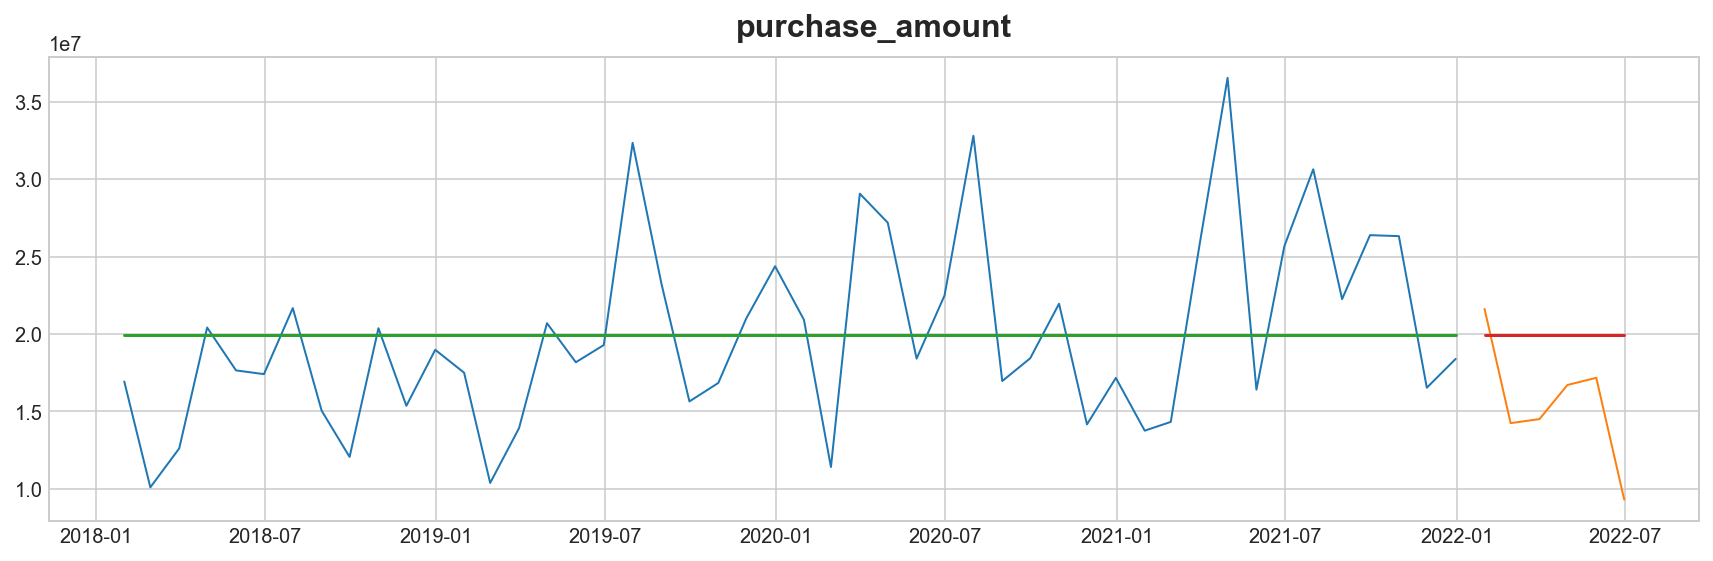

In [37]:
evaluate(target_name='purchase_amount', model_name='baseline')

In [38]:
scores

,model_name,train_score,validate_score
0,baseline,5981145,5699593


In [39]:
for i in range(2, 13):
    model_exponential_moving_average(i)

In [44]:
scores.sort_values(by='train_score').head()

,model_name,train_score,validate_score
1,Exp Moving Average 2,2223777,1311889
2,Exp Moving Average 3,3172940,1854885
3,Exp Moving Average 4,3708251,2149689
12,Moving Average 2,3735455,2818457
18,Moving Average 2,3735455,2818457


In [42]:
for i in range(2, 5):
    model_moving_average(i)

In [43]:
scores

,model_name,train_score,validate_score
0,baseline,5981145,5699593
1,Exp Moving Average 2,2223777,1311889
2,Exp Moving Average 3,3172940,1854885
3,Exp Moving Average 4,3708251,2149689
4,Exp Moving Average 5,4053674,2334040
5,Exp Moving Average 6,4294722,2459952
6,Exp Moving Average 7,4472164,2551309
7,Exp Moving Average 8,4608137,2620575
8,Exp Moving Average 9,4715704,2674877
9,Exp Moving Average 10,4803043,2718582


In [45]:
2_223_777 / 5_981_145 * 100

37.179787482162695

In [47]:
1_311_889 / 5_699_593 * 100

23.017240002926524

In [57]:
X_test.ewm(span=2).mean()

,purchase_amount,baseline
order_date,,
2022-07-31,"8,128,605.72","19,917,920.29"
2022-08-31,"9,833,182.11","19,917,920.29"
2022-09-30,"9,288,707.03","19,917,920.29"
2022-10-31,"8,535,507.27","19,917,920.29"
2022-11-30,"4,347,067.29","19,917,920.29"


In [58]:
X_test.purchase_amount

order_date
2022-07-31    8,128,605.72
2022-08-31   10,401,374.24
2022-09-30    9,046,718.11
2022-10-31    8,172,855.53
2022-11-30    2,278,701.87
Freq: M, Name: purchase_amount, dtype: float64

In [60]:
mean_squared_error(X_test.purchase_amount, X_test.ewm(span=2).mean()) ** 0.5

978882.2946276285

In [51]:
X_test['baseline'] = baseline

In [52]:
mean_squared_error(X_test.purchase_amount, X_test.baseline) ** 0.5

12623978.74188867

In [53]:
978882.29 / 12623978.74 * 100

7.7541503369166795

In [66]:
# weekly group by
df.groupby([pd.Grouper(freq='W-MON'),'customer_name', 'customer_type']).purchase_amount.sum().reset_index()

,order_date,customer_name,customer_type,purchase_amount
0,2018-01-08,Angelo State University,Higher Ed,0.00
1,2018-01-08,Austin Independent School District,K-12,45.00
2,2018-01-08,Beeville Independent School District,K-12,"9,337.80"
3,2018-01-08,Bexar County,Local Government,"267,760.46"
4,2018-01-08,Bexar Metro 9-1-1 Network District,Local Government,"34,785.10"
...,...,...,...,...
17233,2022-11-28,North Texas Municipal Water District,Local Government,"45,833.74"
17234,2022-11-28,Texas Commission on Environmental Quality,State Agency,720.28
17235,2022-11-28,Texas Department of Agriculture,State Agency,"8,830.65"
17236,2022-12-05,Montgomery County Emergency Communications Dis...,Local Government,"1,376.48"


In [69]:
def weekly_summary_df(df):
    '''
    returns results of weekly sales per customer per week
    '''
    return df.groupby([pd.Grouper(freq='W-MON'),'customer_name', 'customer_type'])\
        .purchase_amount.sum().reset_index().set_index('order_date').sort_index()

In [70]:
weekly_summary_df(df)

,customer_name,customer_type,purchase_amount
order_date,,,
2018-01-08,Angelo State University,Higher Ed,0.00
2018-01-08,Austin Independent School District,K-12,45.00
2018-01-08,Beeville Independent School District,K-12,"9,337.80"
2018-01-08,Bexar County,Local Government,"267,760.46"
2018-01-08,Bexar Metro 9-1-1 Network District,Local Government,"34,785.10"
...,...,...,...
2022-11-28,North Texas Municipal Water District,Local Government,"45,833.74"
2022-11-28,Texas Commission on Environmental Quality,State Agency,720.28
2022-11-28,Texas Department of Agriculture,State Agency,"8,830.65"
